In [5]:
#create dictionary: ImagePath, array of FIXMAPS

import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re
import csv
def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.

    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h

    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)

    return horizontal_ppda

def checkObserverRemembered(observer, image_path, base_dir):
    csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
    if not os.path.isfile(csv_file_path):
        print("Error: CSV file not found.")
        return False
    df = pd.read_csv(csv_file_path)
    filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
    if not filtered_rows.empty:
        return True
    else:
        return False

distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
print("ppda", ppda)

def bin_fixations(fixation_map, grid_size=(20, 20)):
    height, width = fixation_map.shape
    binned_map = np.zeros(grid_size)

    bin_height = height // grid_size[0]
    bin_width = width // grid_size[1]

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            bin_area = fixation_map[i*bin_height:(i+1)*bin_height, j*bin_width:(j+1)*bin_width]
            binned_map[i, j] = np.sum(bin_area)
            #ili avg?

    return binned_map

def normalize_map(binned_map):
    return binned_map / np.sum(binned_map)
    #return binned_map

def smooth_map(binned_map, sigma=1):
    return gaussian_filter(binned_map, sigma=sigma)

def process_fixation_map(fixation_map):
    binned_map = bin_fixations(fixation_map)
    normalized_map = normalize_map(binned_map)
    smoothed_map = smooth_map(normalized_map)
    return smoothed_map

def get_current_fixation_map(image_path, coordinates):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    coordinates = coordinates[0:120]
  
    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        if(x_norm >0 and y_norm >0):
            x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm >0 and y_norm <0):
            x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm <0 and y_norm >0):
            x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm <0 and y_norm <0):
            x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1
    #sigma = ppda / np.sqrt(2)
    #fixation_map = gaussian_filter(fixation_map, sigma = sigma)
    fixation_map = cv2.GaussianBlur(fixation_map, (11, 11), 0)
    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)
    return fixation_map

def normalize_fixation_map(fixation_map):
    min_val = np.min(fixation_map)
    max_val = np.max(fixation_map)
    normalized_fixation_map = (fixation_map - min_val) / (max_val - min_val) * 255
    return normalized_fixation_map

# 90experiments folder
base_dir = os.path.abspath(os.path.join(os.getcwd(),"..", "90experiments"))

successful_fixation_maps = {}  # Dictionary to store fixation maps for each imagePath


for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())
    #if(observer != 5):
    #    continue
    if(observer == 1 or observer == 2 or observer == 49 or observer == 50 or observer == 5):
        continue

    #if(observer not in [70,71,73,74,76,77,79,80,82,83,85,87,88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
    #    continue
        
    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('targetImages')]
    #if((filtered_data).empty):
    #    continue
    #print("obs ",observer)
    #print(filtered_data)
    
    uniqueImagePaths = []
    delete_rows = []

    #get only the eye-tracking data from the first viewing
    index = 0
    
    row = filtered_data.iloc[index]
    while len(uniqueImagePaths) < 10:
        row = filtered_data.iloc[index]
        if(row['ImagePath'] not in uniqueImagePaths):
            uniqueImagePaths.append(row['ImagePath'])
            lastImagePath = row['ImagePath']
            index +=1
        elif(row['ImagePath'] in uniqueImagePaths):
            index += 1    
    row = filtered_data.iloc[index]

    while(row['ImagePath'] == lastImagePath):
        index +=1
        row = filtered_data.iloc[index]

    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data = filtered_data.iloc[:index].copy()
    
    grouped = filtered_data.groupby('ImagePath')

    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))
        full_image_path = full_image_path.replace('\\', '/')

        #check if current observer has remembered this image, if not, continue
        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue
        
        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)
        if(np.all(current_fixation_map == 0)):
            continue

        current_fixation_map_20x20 = process_fixation_map(current_fixation_map)
        current_fixation_map_20x20 = normalize_fixation_map(current_fixation_map_20x20)
        
        #current_fixation_map_20x20 = (current_fixation_map)
        #add to dictionary or update it
        if image_path not in successful_fixation_maps:
            successful_fixation_maps[image_path] = [current_fixation_map_20x20]
        else:
            successful_fixation_maps[image_path].append(current_fixation_map_20x20)
    

print("finished all successful")
print(len(successful_fixation_maps['targetImages\\sun_aesdwymqhhiewhyo.jpg']))


ppda 38.81768885920885
finished all successful
26


In [4]:
#create dictionary: ImagePath, array of FIXMAPS

import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re
import csv
def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.

    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h

    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)

    return horizontal_ppda

def checkObserverRemembered(observer, image_path, base_dir):
    csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
    if not os.path.isfile(csv_file_path):
        print("Error: CSV file not found.")
        return False
    df = pd.read_csv(csv_file_path)
    filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
    if not filtered_rows.empty:
        return True
    else:
        return False

distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
print("ppda", ppda)

def bin_fixations(fixation_map, grid_size=(20, 20)):
    height, width = fixation_map.shape
    binned_map = np.zeros(grid_size)

    bin_height = height // grid_size[0]
    bin_width = width // grid_size[1]

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            bin_area = fixation_map[i*bin_height:(i+1)*bin_height, j*bin_width:(j+1)*bin_width]
            binned_map[i, j] = np.sum(bin_area)
            #ili avg?

    return binned_map

def normalize_map(binned_map):
    return binned_map / np.sum(binned_map)
    #return binned_map

def smooth_map(binned_map, sigma=1):
    return gaussian_filter(binned_map, sigma=sigma)

def process_fixation_map(fixation_map):
    binned_map = bin_fixations(fixation_map)
    normalized_map = normalize_map(binned_map)
    smoothed_map = smooth_map(normalized_map)
    return smoothed_map

def get_current_fixation_map(image_path, coordinates):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    coordinates = coordinates[0:120]
  
    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        if(x_norm >0 and y_norm >0):
            x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm >0 and y_norm <0):
            x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm <0 and y_norm >0):
            x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm <0 and y_norm <0):
            x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1
    #sigma = ppda / np.sqrt(2)
    #fixation_map = gaussian_filter(fixation_map, sigma = sigma)
    fixation_map = cv2.GaussianBlur(fixation_map, (11, 11), 0)
    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)
    return fixation_map

def normalize_fixation_map(fixation_map):
    min_val = np.min(fixation_map)
    max_val = np.max(fixation_map)
    normalized_fixation_map = (fixation_map - min_val) / (max_val - min_val) * 255
    return normalized_fixation_map

# 90experiments folder
base_dir = os.path.abspath(os.path.join(os.getcwd(),"..", "90experiments"))

unsuccessful_fixation_maps = {}  # Dictionary to store fixation maps for each imagePath


for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())
    #if(observer != 5):
    #    continue
    if(observer == 1 or observer == 2 or observer == 49 or observer == 50 or observer == 5):
        continue

    #if(observer not in [70,71,73,74,76,77,79,80,82,83,85,87,88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
    #    continue
        
    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('targetImages')]
    #if((filtered_data).empty):
    #    continue
    #print("obs ",observer)
    #print(filtered_data)
    
    uniqueImagePaths = []
    delete_rows = []

    #get only the eye-tracking data from the first viewing
    index = 0
    
    row = filtered_data.iloc[index]
    while len(uniqueImagePaths) < 10:
        row = filtered_data.iloc[index]
        if(row['ImagePath'] not in uniqueImagePaths):
            uniqueImagePaths.append(row['ImagePath'])
            lastImagePath = row['ImagePath']
            index +=1
        elif(row['ImagePath'] in uniqueImagePaths):
            index += 1    
    row = filtered_data.iloc[index]

    while(row['ImagePath'] == lastImagePath):
        index +=1
        row = filtered_data.iloc[index]

    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data = filtered_data.iloc[:index].copy()
    
    grouped = filtered_data.groupby('ImagePath')

    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))
        full_image_path = full_image_path.replace('\\', '/')

        #check if current observer has remembered this image, if not, continue
        if(checkObserverRemembered(observer, image_path, base_dir)):
            continue
        
        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)
        if(np.all(current_fixation_map == 0)):
            continue

        current_fixation_map_20x20 = process_fixation_map(current_fixation_map)
        current_fixation_map_20x20 = normalize_fixation_map(current_fixation_map_20x20)
        
        #current_fixation_map_20x20 = (current_fixation_map)
        #add to dictionary or update it
        if image_path not in unsuccessful_fixation_maps:
            unsuccessful_fixation_maps[image_path] = [current_fixation_map_20x20]
        else:
            unsuccessful_fixation_maps[image_path].append(current_fixation_map_20x20)
    

print("finished all unsuccessful")
print(len(unsuccessful_fixation_maps['targetImages\\sun_aesdwymqhhiewhyo.jpg']))

ppda 38.81768885920885
finished all unsuccessful
2


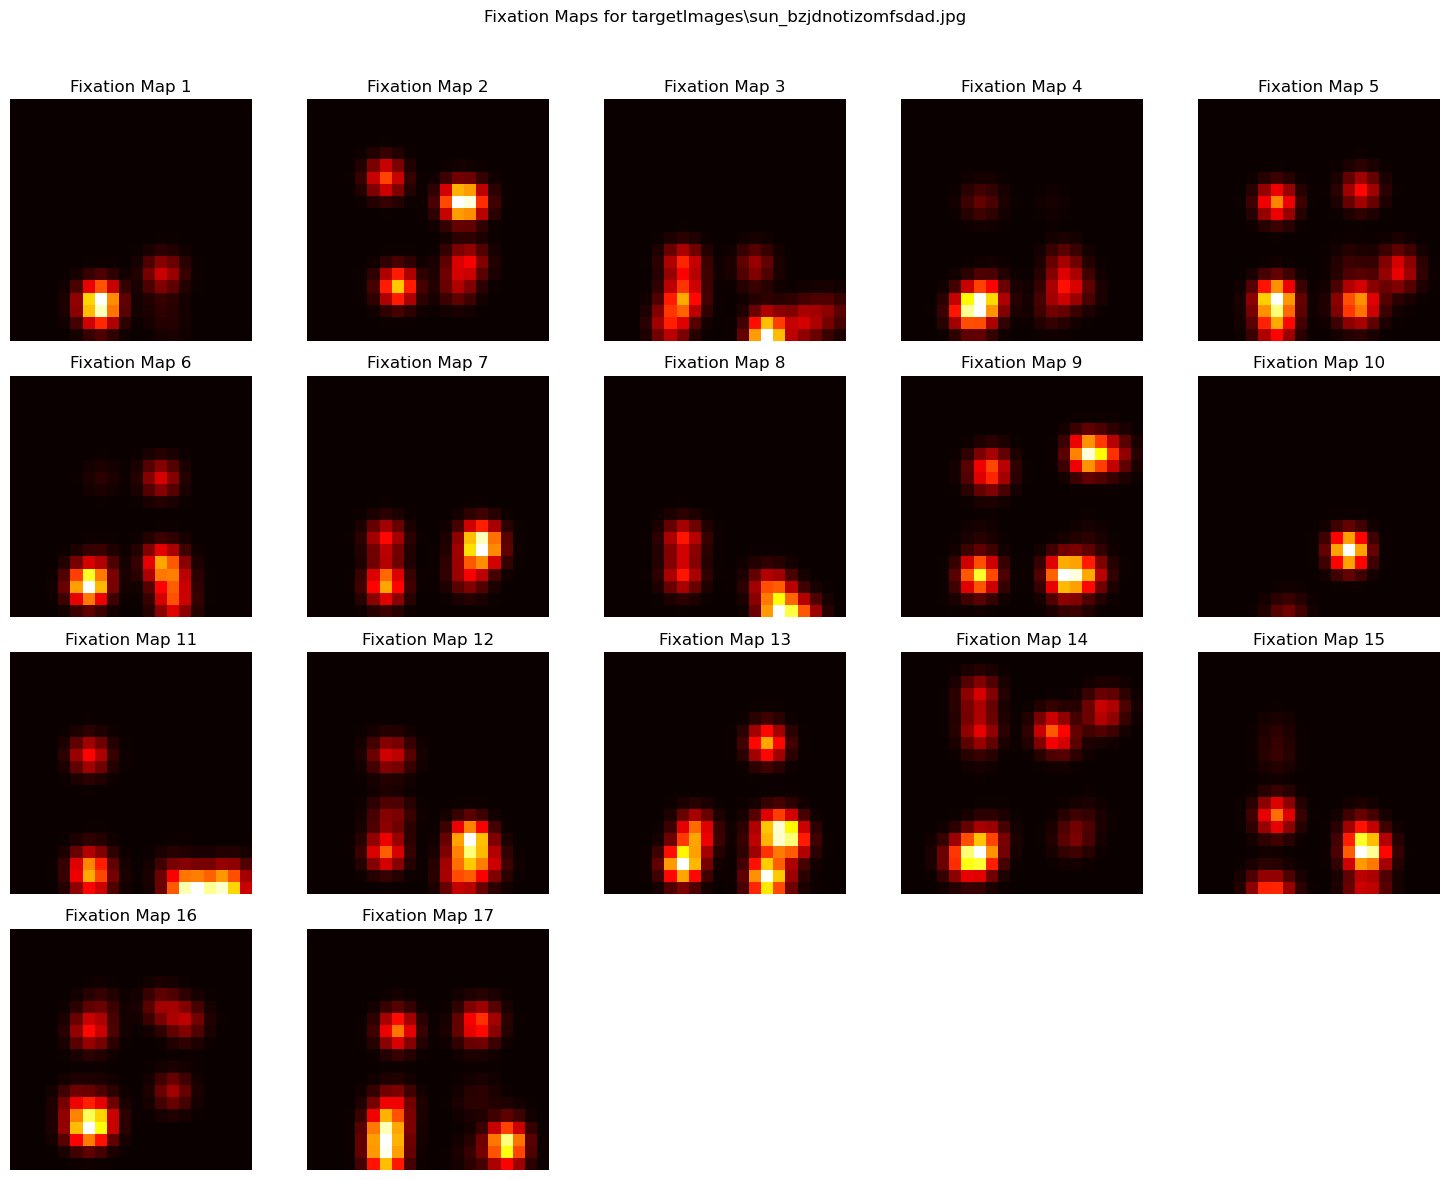

In [26]:
import matplotlib.pyplot as plt
import math

# Specify the keys you want to plot
keys_to_plot = [
    #'targetImages\\sun_amkeeuvicewppjqo.jpg',
    #'targetImages\\sun_apytdxunawwxcvdw.jpg',
    #'targetImages\\sun_arsolpsoaipmhdio.jpg',
    'targetImages\\sun_bzjdnotizomfsdad.jpg'
    # Add more keys as needed
]

# Plot all fixation maps for the specified keys
for key in keys_to_plot:
    if key in successful_fixation_maps:
        fixation_maps = successful_fixation_maps[key]
        
        num_maps = len(fixation_maps)
        grid_size = (int(math.ceil(num_maps / 5)), 5)  # Adjust the number of columns (5 here) as needed
        
        plt.figure(figsize=(15, grid_size[0] * 3))
        
        for i, fixation_map in enumerate(fixation_maps):
            plt.subplot(grid_size[0], grid_size[1], i + 1)
            plt.imshow(fixation_map, cmap='hot', interpolation='nearest')
            plt.title(f'Fixation Map {i + 1}')
            plt.axis('off')
        
        plt.suptitle(f'Fixation Maps for {key}')
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the space for suptitle
        plt.show()
    else:
        print(f"Key {key} not found in unsuccessful_fixation_maps.")


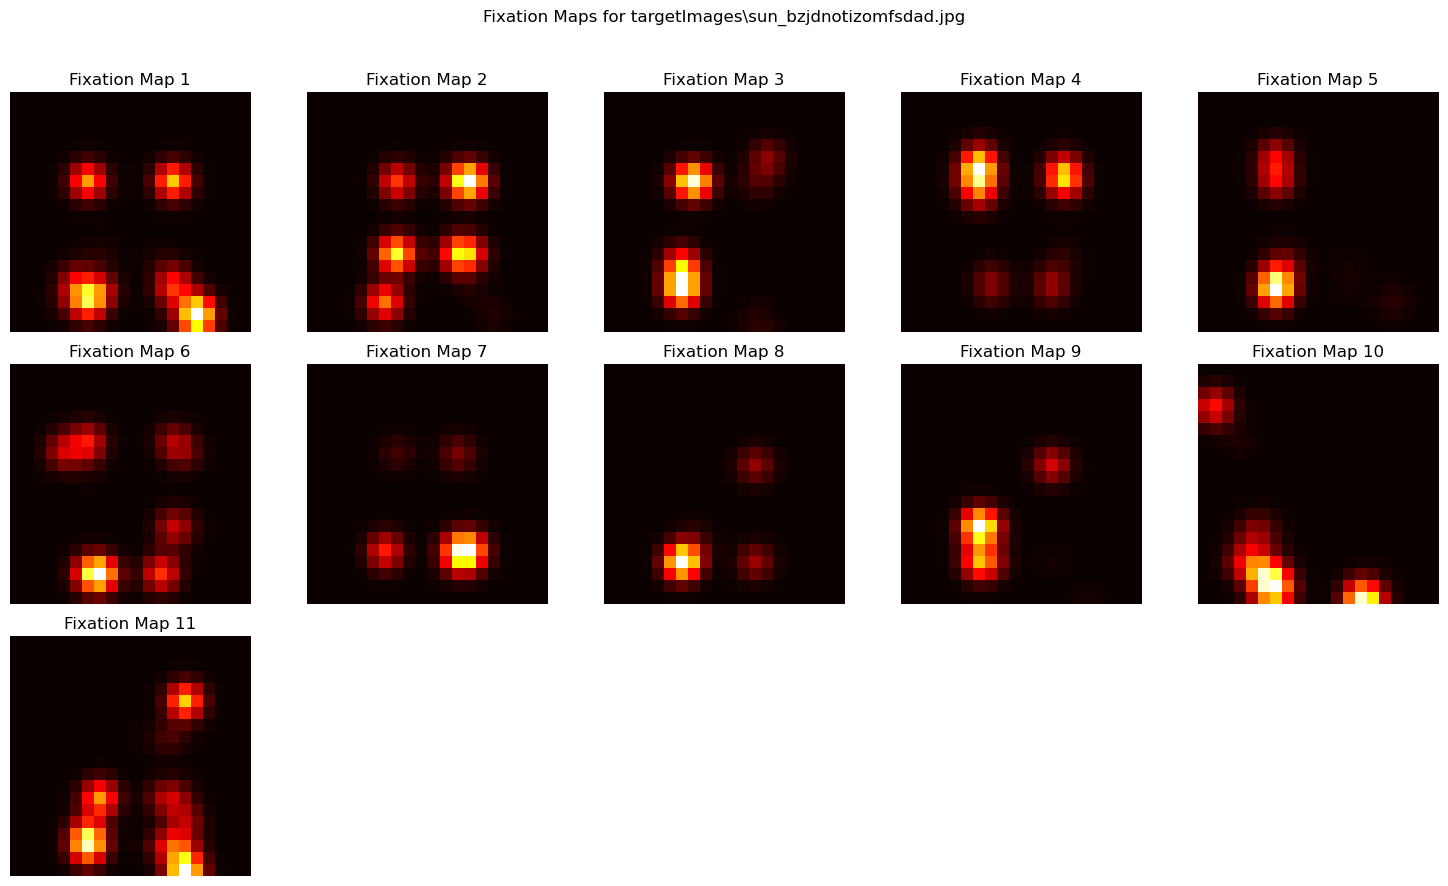

In [27]:
import matplotlib.pyplot as plt
import math

# Specify the keys you want to plot
keys_to_plot = [
    #'targetImages\\sun_amkeeuvicewppjqo.jpg',
    #'targetImages\\sun_apytdxunawwxcvdw.jpg',
    #'targetImages\\sun_arsolpsoaipmhdio.jpg',
    'targetImages\\sun_bzjdnotizomfsdad.jpg'
    # Add more keys as needed
]

# Plot all fixation maps for the specified keys
for key in keys_to_plot:
    if key in unsuccessful_fixation_maps:
        fixation_maps = unsuccessful_fixation_maps[key]
        
        num_maps = len(fixation_maps)
        grid_size = (int(math.ceil(num_maps / 5)), 5)  # Adjust the number of columns (5 here) as needed
        
        plt.figure(figsize=(15, grid_size[0] * 3))
        
        for i, fixation_map in enumerate(fixation_maps):
            plt.subplot(grid_size[0], grid_size[1], i + 1)
            plt.imshow(fixation_map, cmap='hot', interpolation='nearest')
            plt.title(f'Fixation Map {i + 1}')
            plt.axis('off')
        
        plt.suptitle(f'Fixation Maps for {key}')
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the space for suptitle
        plt.show()
    else:
        print(f"Key {key} not found in unsuccessful_fixation_maps.")


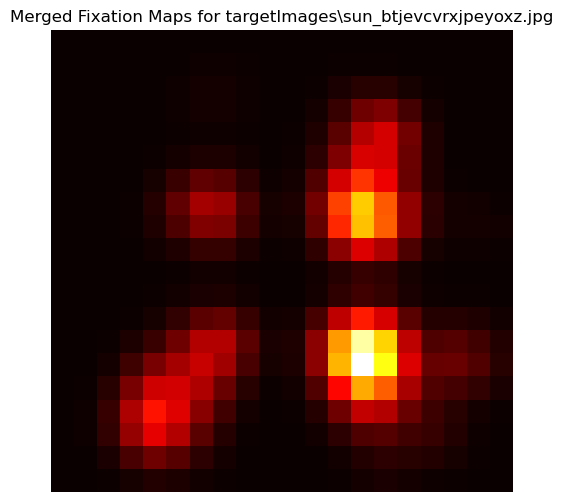

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Function to merge all 20x20 fixation maps into one 20x20 image
def merge_fixation_maps_into_single_image(fixation_maps):
    if not fixation_maps:
        return None
    
    map_size = fixation_maps[0].shape[0]  # Assuming all maps are the same size
    merged_image = np.zeros((map_size, map_size))
    
    for map in fixation_maps:
        merged_image += map
    
    # Normalize the merged image
    if np.max(merged_image) > 0:
        merged_image = merged_image / np.max(merged_image) * 255
    
    return merged_image

# Specify the keys you want to plot
keys_to_plot = [
    #'targetImages\\sun_amkeeuvicewppjqo.jpg',
    #'targetImages\\sun_apytdxunawwxcvdw.jpg',
    #'targetImages\\sun_arsolpsoaipmhdio.jpg'
    'targetImages\\sun_btjevcvrxjpeyoxz.jpg'
    # Add more keys as needed
]

# Plot merged fixation maps for the specified keys
for key in keys_to_plot:
    if key in successful_fixation_maps:
        fixation_maps = successful_fixation_maps[key]
        
        # Merge fixation maps into a single 20x20 image
        merged_image = merge_fixation_maps_into_single_image(fixation_maps)
        
        if merged_image is not None:
            plt.figure(figsize=(6, 6))
            plt.imshow(merged_image, cmap='hot', interpolation='nearest')
            plt.title(f'Merged Fixation Maps for {key}')
            plt.axis('off')
            plt.show()
    else:
        print(f"Key {key} not found in successful_fixation_maps.")


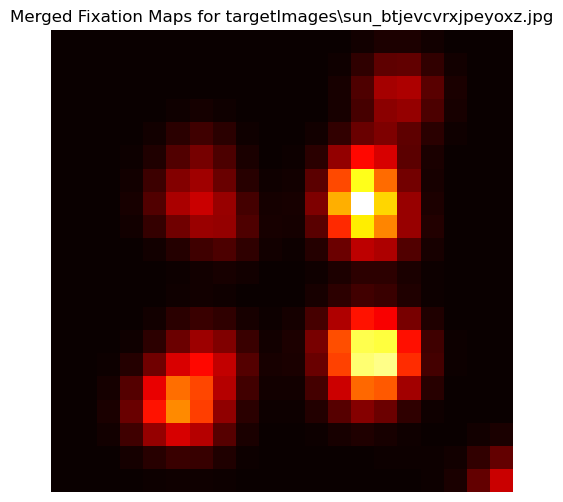

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Function to merge all 20x20 fixation maps into one 20x20 image
def merge_fixation_maps_into_single_image(fixation_maps):
    if not fixation_maps:
        return None
    
    map_size = fixation_maps[0].shape[0]  # Assuming all maps are the same size
    merged_image = np.zeros((map_size, map_size))
    
    for map in fixation_maps:
        merged_image += map
    
    # Normalize the merged image
    if np.max(merged_image) > 0:
        merged_image = merged_image / np.max(merged_image) * 255
    
    return merged_image

# Specify the keys you want to plot
keys_to_plot = [
    #'targetImages\\sun_amkeeuvicewppjqo.jpg',
    #'targetImages\\sun_apytdxunawwxcvdw.jpg',
    #'targetImages\\sun_arsolpsoaipmhdio.jpg',
    'targetImages\\sun_btjevcvrxjpeyoxz.jpg'
    # Add more keys as needed
]

# Plot merged fixation maps for the specified keys
for key in keys_to_plot:
    if key in unsuccessful_fixation_maps:
        fixation_maps = unsuccessful_fixation_maps[key]
        
        # Merge fixation maps into a single 20x20 image
        merged_image = merge_fixation_maps_into_single_image(fixation_maps)
        
        if merged_image is not None:
            plt.figure(figsize=(6, 6))
            plt.imshow(merged_image, cmap='hot', interpolation='nearest')
            plt.title(f'Merged Fixation Maps for {key}')
            plt.axis('off')
            plt.show()
    else:
        print(f"Key {key} not found in unsuccessful_fixation_maps.")
